In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from ECG_function import *
%matplotlib inline

# "Naive" Wavelet Transformation
## Data Importing

In [3]:
Xtrain,Ytrain,Xtest = DataImporting()
lable = Ytrain.TARGET.values

In [4]:
#test
DataSample(Xtrain,[1,2],1)

,ML1_0,ML1_1,ML1_2,ML1_3,ML1_4,ML1_5,ML1_6,ML1_7,ML1_8,ML1_9,...,ML1_740,ML1_741,ML1_742,ML1_743,ML1_744,ML1_745,ML1_746,ML1_747,ML1_748,ML1_749
1,0.018403,0.026159,0.009684,0.001014,-0.000866,0.002019,0.000617,-0.011167,-0.026314,-0.026881,...,-0.030683,-0.027179,-0.023822,-0.021767,-0.021504,-0.022533,-0.023832,-0.023974,-0.021915,-0.017584
2,-0.020974,-0.044294,-0.044097,-0.042136,-0.041125,-0.034392,-0.033026,-0.031817,-0.032347,-0.034317,...,0.013544,-0.013377,-0.038524,-0.038650,-0.039073,-0.051832,-0.069153,-0.081822,-0.086272,-0.088153


## Feature Collection
We consider a fft transformation for all the 12 channels's signals.

(1000, 12, 778)
(1000, 9336)


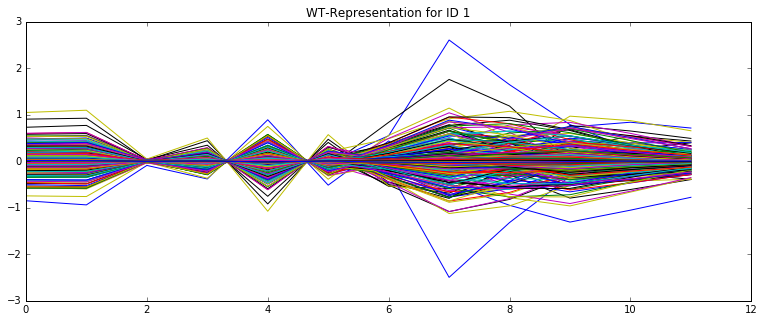

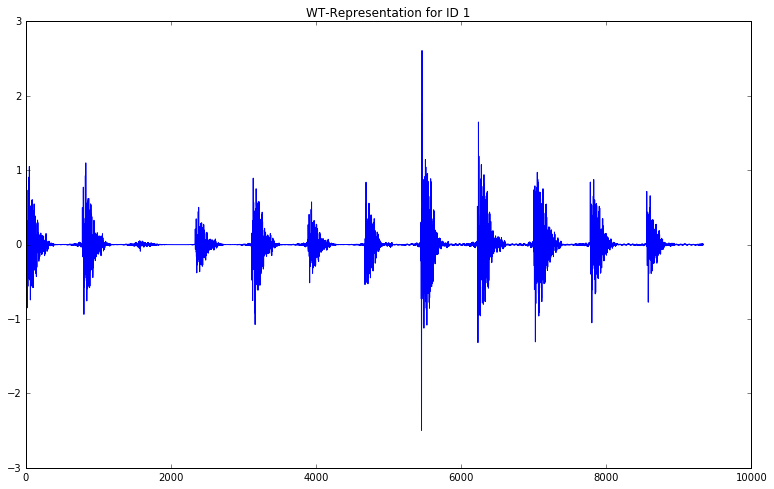

In [45]:
import pywt
from scipy.fftpack import dct

AllFeatures_wt_fft =[[[] for k in range(12)   ] for i in range(1000)]
for id in range(1000):
    for k in range(12):
        AllFeatures_wt_fft[id][k] = list(dct(list(pywt.dwt(DataSample(Xtrain,id,k+1).values, 'db10'))[0],norm = "ortho"))+list(dct(list(pywt.dwt(DataSample(Xtrain,id,k+1).values, 'db20'))[1],norm = "ortho"))
        
        
#test for id 1
plt.figure(figsize=(13,5))
plt.plot(AllFeatures_wt_fft[1])
plt.title("WT-Representation for ID 1")
print np.shape(AllFeatures_wt_fft)
import itertools
for id in range(1000):
    AllFeatures_wt_fft[id] = list(itertools.chain(*AllFeatures_wt_fft[id]))
print np.shape(AllFeatures_wt_fft)
plt.figure(figsize=(13,8))
plt.plot(AllFeatures_wt_fft[1])
plt.title("WT-FFT-Representation for ID 1")

In [53]:
# from scipy import signal
# AllFeatures_wt =[[] for i in range(1000)]
# for id in range(1000):
#     for k in range(1,13):
#         AllFeatures_wt[id] += list(signal.cwt(np.array(DataSample(Xtrain,id,k).values), signal.ricker,np.arange(1,10)))
# print np.shape(AllFeatures_wt)
# import itertools
# for id in range(1000):
#     AllFeatures_wt[id] = list(itertools.chain(*AllFeatures_wt[id]))
# print np.shape(AllFeatures_wt)
# plt.figure(figsize=(13,8))
# plt.plot(AllFeatures_wt[1])
# plt.title("WT-Representation for ID 1")        

## Feature Selction
We will use a classic F-test method.

In [71]:
from sklearn.feature_selection import SelectKBest, f_classif
N_sep = len(lable)*4/5

Select = SelectKBest(f_classif, k=110)
Select.fit(AllFeatures_wt_fft[0:N_sep], lable[0:N_sep])
SelectedFeatures = Select.transform(AllFeatures_wt_fft)
np.shape(SelectedFeatures)

(1000, 110)

# Classification
## Gaussian NB

In [72]:
from sklearn.naive_bayes import GaussianNB 


gnb = GaussianNB()
gnb.fit(SelectedFeatures[0:N_sep], lable[0:N_sep])
print gnb.score(SelectedFeatures[N_sep:], lable[N_sep:])
feat_pred_gnb = gnb.predict(SelectedFeatures[N_sep:])

0.645


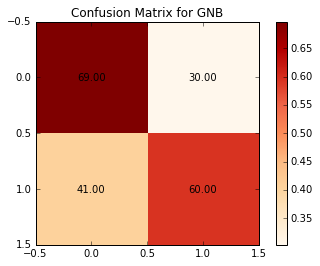

In [73]:
PlotCM(lable[N_sep:],feat_pred_gnb,'GNB')

## SVM
We select the kernel linear.

In [74]:
from sklearn import svm
svm = svm.SVC(kernel='linear')#‘linear!!!’ or 'poly'
svm.fit(SelectedFeatures[0:N_sep], lable[0:N_sep])
print svm.score(SelectedFeatures[N_sep:], lable[N_sep:])
feat_pred_svm = svm.predict(SelectedFeatures[N_sep:])

0.62


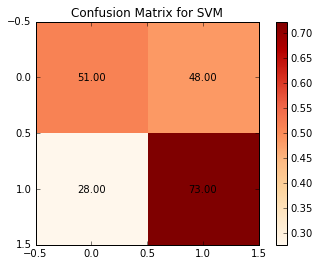

In [75]:
PlotCM(lable[N_sep:],feat_pred_svm,'SVM')

## Random Forest
We set the n_estimetors = 500.

In [76]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(n_estimators=100)
RF.fit(SelectedFeatures[0:N_sep], lable[0:N_sep])
print RF.score(SelectedFeatures[N_sep:], lable[N_sep:])
feat_pred_rf = RF.predict(SelectedFeatures[N_sep:])

0.705


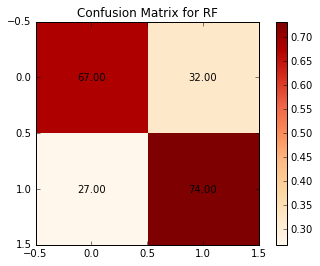

In [77]:
PlotCM(lable[N_sep:],feat_pred_rf,'RF')

## BenchMark for Different Number of Features

In [ ]:
k_gnb = []
k_svm = []
k_rf = []

for num_feature in range(100,2000,100):
    Selec = SelectKBest(f_classif, k = num_feature )
    train_data_features = Selec.fit_transform(AllFeatures_wt, lable)
    
    #GNB
    gnb.fit(train_data_features[0:N_sep], lable[0:N_sep])
    k_gnb.append(gnb.score(train_data_features[N_sep:], lable[N_sep:]))
    
    #SVM  
    svm.fit(train_data_features[0:N_sep], lable[0:N_sep])
    k_svm.append(svm.score(train_data_features[N_sep:], lable[N_sep:]))
    
    #RF
    RF.fit(train_data_features[0:N_sep], lable[0:N_sep])
    k_rf.append(RF.score(train_data_features[N_sep:], lable[N_sep:]))
    


In [ ]:
BenchMark = pd.DataFrame({"GNB":k_gnb,"SVM":k_svm,'RF':k_rf})
BenchMark.index = ["k = "+ str(i) for i in range(100,2000,100)]
BenchMark

In [ ]:
plt.figure(figsize = (10,7))
plt.plot(BenchMark["GNB"])
plt.plot(BenchMark["SVM"])
plt.plot(BenchMark["RF"])
plt.xticks(range(0,19),range(100,2000,100))
plt.legend(['GNB','SVM','RF'])
plt.xlabel("Number of Features K")
plt.ylabel("Accuaracy rate 2:1 train-test split")
plt.title("Benchmark for differents classifiers against number of features (K)")

In [ ]:
k_gnb = []
k_svm = []
k_rf = []

for num_feature in range(10,200,10):
    Selec = SelectKBest(f_classif, k = num_feature )
    train_data_features = Selec.fit_transform(AllFeatures_wt, lable)
    
    #GNB
    gnb.fit(train_data_features[0:N_sep], lable[0:N_sep])
    k_gnb.append(gnb.score(train_data_features[N_sep:], lable[N_sep:]))
    
    #SVM  
    svm.fit(train_data_features[0:N_sep], lable[0:N_sep])
    k_svm.append(svm.score(train_data_features[N_sep:], lable[N_sep:]))
    
    #RF
    RF.fit(train_data_features[0:N_sep], lable[0:N_sep])
    k_rf.append(RF.score(train_data_features[N_sep:], lable[N_sep:]))
    

In [ ]:
BenchMark2 = pd.DataFrame({"GNB":k_gnb,"SVM":k_svm,'RF':k_rf})
BenchMark2.index = ["k = "+ str(i) for i in range(10,200,10)]
BenchMark2

In [ ]:
plt.figure(figsize = (10,7))
plt.plot(BenchMark2["GNB"])
plt.plot(BenchMark2["SVM"])
plt.plot(BenchMark2["RF"])
plt.xticks(range(0,19),range(10,200,10))
plt.legend(['GNB','SVM','RF'])
plt.xlabel("Number of Features K")
plt.ylabel("Accuaracy rate 2:1 train-test split")
plt.title("Benchmark for differents classifiers against number of features (K)")

### With these plots, we consider of using the algorithm RF with K = 300.

## Cross-Validation

In [ ]:
from sklearn import cross_validation
scores  = cross_validation.cross_val_score(RF, SelectedFeatures, lable, cv=10)
print(scores)
print(np.mean(scores))

## Some other plots

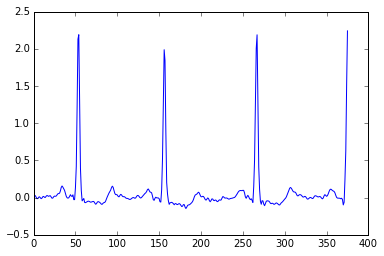

In [45]:
plt.plot(pywt.dwt(DataSample(Xtrain,id,1).values, 'db2')[0])

In [7]:
import pywt

AllFeatures_wt =[[[] for k in range(12)] for i in range(1000)]
for id in range(1000):
    for k in range(12):
        AllFeatures_wt[id][k] = list(pywt.dwt(DataSample(Xtrain,id,k+1).values, 'db2'))
#test for id 1


(2, 376)


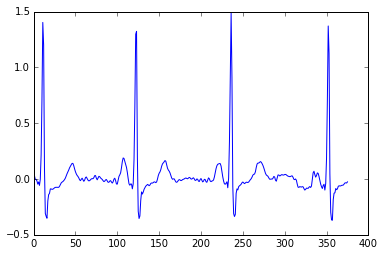

In [23]:
print np.shape(AllFeatures_wt[1][1])
plt.plot(AllFeatures_wt[1][1][0])


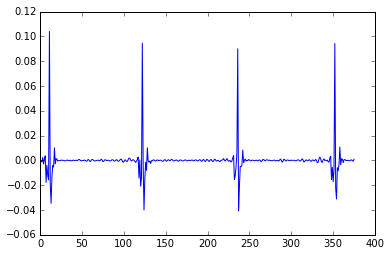

In [21]:
plt.plot(AllFeatures_wt[1][3][1])

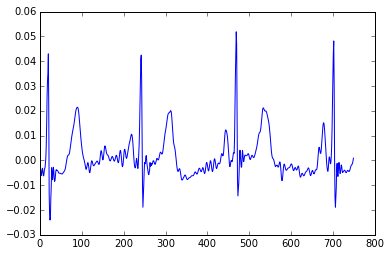

In [22]:
plt.plot(DataSample(Xtrain,1,3))

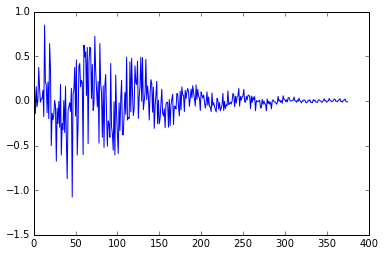

In [25]:
from scipy.fftpack import dct, idct
plt.plot(list(dct(AllFeatures_wt[1][1][0], norm='ortho')))

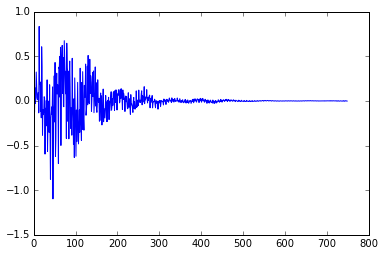

In [32]:
plt.plot(list(dct(DataSample(Xtrain,1,1),norm ='ortho')))
#list(dct(AllFeatures_wt[1][1][0], norm='ortho'))

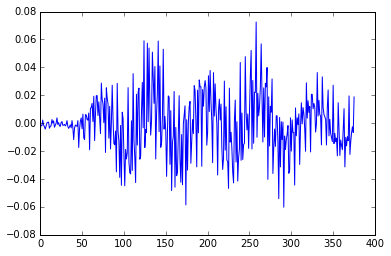

In [33]:
plt.plot(list(dct(AllFeatures_wt[1][1][1], norm='ortho')))

In [10]:
list(pywt.dwt(DataSample(Xtrain,1,1).values, 'db2'))[0]

array([  2.87682929e-02,   3.28098941e-02,   5.06982774e-03,
         2.85398400e-03,  -1.14627402e-02,  -3.72344958e-02,
        -2.07363514e-02,  -5.44148110e-02,  -7.80001924e-03,
         1.84249903e-01,   6.59130632e-01,   1.36445171e+00,
         1.22780522e+00,   1.30981674e-01,  -2.92708585e-01,
        -3.28022426e-01,  -3.42912262e-01,  -1.91343787e-01,
        -1.28129545e-01,  -1.19632742e-01,  -8.30633005e-02,
        -8.35103565e-02,  -8.64537723e-02,  -8.42412684e-02,
        -7.85571433e-02,  -7.16181475e-02,  -6.74669208e-02,
        -6.65673019e-02,  -6.74901201e-02,  -6.93579902e-02,
        -6.88263216e-02,  -6.09106686e-02,  -4.74281425e-02,
        -3.62977575e-02,  -3.06395922e-02,  -2.58625629e-02,
        -1.92267303e-02,  -1.25079792e-02,  -2.78985165e-03,
         1.35321815e-02,   3.04311437e-02,   4.34979231e-02,
         5.79257495e-02,   7.39002318e-02,   8.61811417e-02,
         9.77367646e-02,   1.10014710e-01,   1.12054385e-01,
         9.71189613e-02,